# Builds for Gypsy mod

Developed for gypsy 1.36.1

In [1]:

import random
import bisect 
import numpy as np
from collections import Counter, defaultdict
import copy

import yaml

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

## Load data

In [3]:
IDEAS_PATHS = [
    '../data/processed/gypsy-1-36-1/00_basic_ideas.yaml', 
    '../data/processed/gypsy-1-36-1/00_flogi_ideas.yaml', 
]

class Idea():
    def __init__(self, name:str, type: str, effect: dict):
        self.name = name
        self.type = type
        self.effect = effect

    def __repr__(self):
        return f'Idea({self.name}, {self.type}, {self.effect})'

IDEAS = {}
IDEA_PROTECTED_KEYS = ['category']
for path in IDEAS_PATHS:
    with open(path, 'r') as f:
        ideas_dict = yaml.load(f, Loader=yaml.FullLoader)
    for name, value in ideas_dict.items():
        category = value['category']
        effect = Counter()
        for key in value.keys():
            if key not in IDEA_PROTECTED_KEYS:
                effect_set = value[key]
                for k, v in effect_set.items():
                    effect[k] += abs(v)
        IDEAS[name] = Idea(name=name, type=category, effect=effect)


In [4]:
POLICIES_PATHS = [
    '../data/processed/gypsy-1-36-1/Idea_Variation_policies.yaml'
]

class Policy():
    def __init__(self, name:str, type: str, req: tuple, effect: dict):
        self.name = name
        self.type = type.upper()
        self.req = req
        self.effect = effect
        assert self.type in ['ADM', 'DIP', 'MIL']

    def __repr__(self):
        return f"Policy({self.name}, {self.type}, {self.req}, {self.effect})"

POLICIES = {}
POLICY_PROTECTED_KEYS = ['monarch_power', 'req']
for path in POLICIES_PATHS:
    with open(path, 'r') as f:
        policies_dict = yaml.load(f, Loader=yaml.FullLoader)
    for name, value in policies_dict.items():
        monarch_power = value['monarch_power']
        req0, req1 = value['req']
        effect = Counter()
        for key in value.keys():
            if key not in POLICY_PROTECTED_KEYS:
                effect[key] = abs(value[key])
        POLICIES[name] = Policy(
                name = name, 
                type = value['monarch_power'], 
                req = (req0, req1),
                effect = effect
            )


## Build ideas

In [5]:
ADM_IDEA_NAMES = ['administrative_ideas', 'economic_ideas', 'expansion_ideas', 'humanist_ideas', 'innovativeness_ideas',
                  'centralisation0', 'decentralisation0', 'development0', 'jurisprudence0', 'state_administration0', 'strongman0',]
REL_IDEA_NAMES = ['catholic0']
GOV_IDEA_NAMES = ['monarchy0']
ADM_NOT_COMPATIBLE = [
    ('strongfem0', 'strongman0',),
    ('centralisation0', 'decentralisation0',),
]
ADM_IDEA_SCOPE = ADM_IDEA_NAMES + REL_IDEA_NAMES + GOV_IDEA_NAMES
ADM_IDEA_SCOPE_SET = set(ADM_IDEA_SCOPE)
ADM_IDEA_SCOPE_COUNT = len(ADM_IDEA_SCOPE)

DIP_IDEA_NAMES = ['dynasty0', 'exploration_ideas', 'influence_ideas', 'maritime_ideas', 'spy_ideas', 'trade_ideas', 'assimilation0',
                  'colonial_empire0', 'fleet_base0', 'galley0', 'heavy_ship0', 'light_ship0', 'nationalism0', 'propaganda0', 'society0']
IMP_IDEA_NAMES = ['imperialism0',]
DIP_NOT_COMPATIBLE = [
    ('galley0', 'heavy_ship0'),
    ('galley0', 'light_ship0'),
    ('heavy_ship0', 'light_ship0'),
]
DIP_IDEA_SCOPE = DIP_IDEA_NAMES + IMP_IDEA_NAMES
DIP_IDEA_SCOPE_SET = set(DIP_IDEA_SCOPE)
DIP_IDEA_SCOPE_COUNT = len(DIP_IDEA_SCOPE)

MIL_IDEA_NAMES = ['offensive0', 'defensive0', 'quality0', 'quantity0', 'general_staff0', 'standing_army0', 'conscription0',
                  'mercenary0', 'weapon_quality0', 'fortress0', 'war_production0', 'tactical0', 'militarism0', 'fire0', 'shock0',]
MIL_NOT_COMPATIBLE = [
    ('offensive0', 'defensive0'),
    ('quality0', 'quantity0'),
    ('standing_army0', 'conscription0'),
    ('fire0', 'shock0')
]
MIL_IDEA_SCOPE = MIL_IDEA_NAMES
MIL_IDEA_SCOPE_SET = set(MIL_IDEA_SCOPE)
MIL_IDEA_SCOPE_COUNT = len(MIL_IDEA_SCOPE)

ALL_IDEA_NAMES = ADM_IDEA_SCOPE + DIP_IDEA_SCOPE + MIL_IDEA_SCOPE
ALL_IDEA_COUNT = len(ALL_IDEA_NAMES)

# Check if all idea names are valid
for idea_name in ALL_IDEA_NAMES:
    if idea_name not in IDEAS:
        print(f'Idea {idea_name} not found!')
        exit()


## Build score

In [6]:
# Print all possible effects of ideas and the max value of each effect
all_idea_effects = set()
for idea in IDEAS.values():
    all_idea_effects.update(idea.effect.keys())
all_idea_effects = sorted(list(all_idea_effects))
for effect in all_idea_effects:
    max_value = max([abs(idea.effect[effect]) for idea in IDEAS.values()])
    min_value = min([abs(idea.effect[effect]) for idea in IDEAS.values()])
    different_sign = min_value * max_value < 0
    print(f'{effect}: {max_value} {"(different sign)" if different_sign else ""}')

accept_vassalization_reasons: 15 
adm_tech_cost_modifier: 0.1 
admiral_cost: 0.5 
advisor_cost: 0.2 
advisor_pool: 1 
ae_impact: 0.15 
all_estate_loyalty_equilibrium: 0.1 
all_estate_possible_privileges: 1 
allow_mercenary_drill: 1 
allowed_marine_fraction: 0.25 
army_tradition: 1 
army_tradition_decay: 0.01 
artillery_cost: 0.15 
artillery_levels_available_vs_fort: 1 
artillery_power: 0.15 
autonomy_change_time: 0.5 
backrow_artillery_damage: 0.1 
blockade_efficiency: 0.5 
brahmins_hindu_loyalty_modifier: 0.1 
brahmins_muslim_loyalty_modifier: 0.1 
build_cost: 0.25 
build_time: 0.33 
burghers_loyalty_modifier: 0.1 
can_fabricate_for_vassals: 1 
caravan_power: 0.25 
cav_to_inf_ratio: 0.3 
cavalry_cost: 0.33 
cavalry_flanking: 1.0 
cavalry_power: 0.25 
cb_on_overseas: 1 
cb_on_primitives: 1 
cb_on_religious_enemies: 1 
center_of_trade_upgrade_cost: 0.2 
church_loyalty_modifier: 0.1 
church_power_modifier: 0.75 
claim_duration: 0.25 
colonist_placement_chance: 0.15 
colonists: 2 
core_cr

In [7]:
# Print all possible effects of policies and the max value of each effect
all_policy_effects = set()
for policy in POLICIES.values():
    all_policy_effects.update(policy.effect.keys())
all_policy_effects = sorted(list(all_policy_effects))
for effect in all_policy_effects:
    max_value = max([abs(policy.effect[effect]) for policy in POLICIES.values()])
    min_value = min([abs(policy.effect[effect]) for policy in POLICIES.values()])
    different_sign = min_value * max_value < 0
    print(f"{effect}: {min_value:.2f} - {max_value:.2f}   {'different sign' if different_sign else ''}")

advisor_cost: 0.00 - 0.10   
advisor_pool: 0.00 - 5.00   
ae_impact: 0.00 - 0.15   
army_tradition: 0.00 - 1.00   
army_tradition_decay: 0.00 - 0.01   
artillery_cost: 0.00 - 0.20   
artillery_power: 0.00 - 0.15   
build_cost: 0.00 - 0.15   
build_time: 0.00 - 0.25   
caravan_power: 0.00 - 0.25   
cav_to_inf_ratio: 0.00 - 0.10   
cavalry_power: 0.00 - 0.10   
colonist_placement_chance: 0.00 - 0.15   
colonists: 0.00 - 1.00   
core_creation: 0.00 - 0.15   
culture_conversion_cost: 0.00 - 0.20   
defensiveness: 0.00 - 0.10   
development_cost: 0.00 - 0.10   
development_cost_in_primary_culture: 0.00 - 0.10   
devotion: 0.00 - 1.00   
diplomatic_annexation_cost: 0.00 - 0.15   
diplomatic_reputation: 0.00 - 2.00   
diplomatic_upkeep: 0.00 - 2.00   
diplomats: 0.00 - 1.00   
discipline: 0.00 - 0.05   
drill_gain_modifier: 0.00 - 0.25   
embargo_efficiency: 0.00 - 0.25   
embracement_cost: 0.00 - 0.20   
enemy_core_creation: 0.00 - 0.50   
fire_damage: 0.00 - 0.07   
fire_damage_received: 0.

In [8]:
# Country weights are used to determine the score of a country during peace time
COUNTRY_WEIGHTS = {
    # Development
    'development_cost': 150,                        # Each 10% is 15 points
    'development_cost_in_primary_culture': 100,     # Each 10% is 10 points
    # Mana
    'country_admin_power': 25,                      # Each point is 100 points
    'country_diplomatic_power': 25,                 # Each point is 100 points
    # Policies
    'free_policy': 5,                               # Each free extra policy is 5 points
    'free_adm_policy': 2,                           # Each free extra policy is 2 points
    'free_dip_policy': 2,                           # Each free extra policy is 2 points
    'free_mil_policy': 1,                           # Each free extra policy is 1 points
    'possible_policy': 12,                          # Each extra policy column is 12 points
    'possible_adm_policy': 4,                       # Each possible policy is 4 points
    'possible_dip_policy':  4,                      # Each possible policy is 4 points
    'possible_mil_policy': 4,                       # Each possible policy is 4 points
    # Tech and idea cost        
    'technology_cost': 60,                           # Each 10% discount is 6 points
    'adm_tech_cost_modifier': 20,                    # Each 10% discount is 2 point
    'dip_tech_cost_modifier':  20,                   # Each 10% discount is 2 point
    'mil_tech_cost_modifier':  20,                   # Each 10% discount is 2 point
    'idea_cost': 60,                                 # Each 10% discount is 6 points
    # State     
    'governing_capacity_modifier': 30,              # Each 10% is 3 points
    'advisor_cost': 10,                             # Each 10% discount is 1 point
    'monthly_reform_progress_modifier': 20,         # Each 10% is 2 point
    'monthly_reform_progress': 10,                  # Each point is 10 point
    'reform_progress_growth': 20,                   # Each 10% is 2 point
    # Economy       
    'global_tax_modifier': 5,                       # Each 10% is 0.5 point
    'production_efficiency': 5,                     # Each 10% is 0.5 point
    'global_trade_goods_size_modifier': 5,          # Each 10% is 0.5 point
    'trade_efficiency': 5,                          # Each 10% is 0.5 point
    # Buildings     
    'build_cost': 20,                               # Each 10% discount is 2 points
}

# War weights are used to determine the score of a country during war time and to find the best policies
MILITARY_WEIGHTS ={
    # Main modifiers
    'discipline': 300,                              # Each 10% is 30 points
    'fire_damage': 150,                             # Each 10% is 15 points
    'fire_damage_received': 150,                    # Each 10% is 15 points
    'shock_damage': 150,                            # Each 10% is 15 points
    'shock_damage_received': 150,                   # Each 10% is 15 points
    'land_morale': 150,                             # Each 10% is 15 points
    'army_tradition': 10,                           # Each 10% is 1 points
    # Infantry  
    'infantry_power': 150,                          # Each 10% is 15 points
    'infantry_cost': 10,                            # Each 10% discount is 1 points
    # Cavalry   
    'cavalry_power': 150,                           # Each 10% is 15 points
    'cavalry_flanking': 10,                         # Each point is 10 points
    # Artillery 
    'artillery_power': 150,                         # Each 10% is 15 points
    'backrow_artillery_damage': 100,                # Each 10% is 10 points
    # Army  
    'global_manpower_modifier': 50,                 # Each 10% is 5 points
    'land_forcelimit_modifier': 50,                 # Each 10% is 5 points
    'land_maintenance_modifier': 20,                # Each 10% discount is 2 points
    'manpower_recovery_speed': 20,                  # Each 10% is 2 points
    'manpower_in_true_faith_provinces': 20,         # Each 10% is 2 points
    # Defensiveness
    'defensiveness': 10,                            # Each 10% is 1 points
    'fort_maintenance_modifier': 5,                 # Each 10% discount is 0.5 points
    'siege_ability': 5,                             # Each 10% is 0.5 points
}


In [9]:
EXTRA_WEIGHTS = {
    'nationalism0': 50,              # Estate interaction - main +1 ADM and +1 DIP
    'centralisation0': 20            # Allow development_over_25
}

In [10]:
HIGHLIGHTS = [
    'development_cost',
    'development_cost_in_primary_culture',
    'idea_cost',
    'technology_cost',
    'discipline',
    'fire_damage',
    'fire_damage_received',
    'shock_damage',
    'shock_damage_received',
    'land_morale',
    'infantry_power',
    'cavalry_power',
    'artillery_power',
]

In [11]:
def get_score(effects: dict, weights: list[dict]):
    score = 0
    for weight in weights:
        for key, value in weight.items():
            if key in effects:
                score += value * effects[key]
    return score

In [12]:
def get_development_effect(effects):
    return effects['development_cost'] + effects['development_cost_in_primary_culture']

def get_adm_tech_effect(effects):
    return effects['adm_tech_cost_modifier'] + effects['technology_cost']

def get_dip_tech_effect(effects):
    return effects['dip_tech_cost_modifier'] + effects['technology_cost']

def get_mil_tech_effect(effects):
    return effects['mil_tech_cost_modifier'] + effects['technology_cost']

def get_idea_effect(effects):
    return effects['idea_cost']

## Precompute policies for idea couples

In [13]:
IDEA_SCORE = {}
for idea_name in ALL_IDEA_NAMES:
    idea = IDEAS[idea_name]
    score = get_score(idea.effect, [COUNTRY_WEIGHTS, MILITARY_WEIGHTS]) + EXTRA_WEIGHTS.get(idea_name, 0)
    IDEA_SCORE[idea_name] = score
    
IDEA_POLICY_POTENTIAL = defaultdict(list)
for policy in POLICIES.values():
    req0, req1 = policy.req
    for req0_1 in req0:
        IDEA_POLICY_POTENTIAL[req0_1].append(policy)
    for req1_1 in req1:
        IDEA_POLICY_POTENTIAL[req1_1].append(policy)
        
IDEA_NOT_COMPATIBLE = defaultdict(list)
for idea_1, idea_2 in ADM_NOT_COMPATIBLE + DIP_NOT_COMPATIBLE + MIL_NOT_COMPATIBLE:
    IDEA_NOT_COMPATIBLE[idea_1].append(idea_2)
    IDEA_NOT_COMPATIBLE[idea_2].append(idea_1)

In [14]:
POLICY_LIB = {}
for policy in POLICIES.values():
    req0, req1 = policy.req
    for req0_1 in req0:
        for req1_1 in req1:
            policy_id = tuple(sorted([req0_1, req1_1]))
            POLICY_LIB[policy_id] = policy
            
POLICY_WAR_SCORE = {}
for policy in POLICIES.values():
    score = get_score(policy.effect, [MILITARY_WEIGHTS])
    POLICY_WAR_SCORE[policy.name] = score
    
DEV_POLICY_SET = set([policy.name for policy in POLICIES.values() if policy.effect.get('development_cost', 0) != 0 or policy.effect.get('development_cost_in_primary_culture', 0) != 0])
ADM_TECH_POLICY_SET = set([policy.name for policy in POLICIES.values() if policy.effect.get('adm_tech_cost_modifier', 0) != 0 or policy.effect.get('technology_cost', 0) != 0])
DIP_TECH_POLICY_SET = set([policy.name for policy in POLICIES.values() if policy.effect.get('dip_tech_cost_modifier', 0) != 0 or policy.effect.get('technology_cost', 0) != 0])
MIL_TECH_POLICY_SET = set([policy.name for policy in POLICIES.values() if policy.effect.get('mil_tech_cost_modifier', 0) != 0 or policy.effect.get('technology_cost', 0) != 0])
IDEA_POLICY_SET = set([policy.name for policy in POLICIES.values() if policy.effect.get('idea_cost', 0) != 0])

## Idea potential filter

In [15]:
idea_potential_score = {}
for idea_name in ALL_IDEA_NAMES:
    idea = IDEAS[idea_name]
    idea_potential_score[idea_name] = get_score(idea.effect, [COUNTRY_WEIGHTS, MILITARY_WEIGHTS]) + EXTRA_WEIGHTS.get(idea_name, 0)

Mean: 26.28
Std: 22.53
Min: 0.00
Max: 79.50
Median: 21.43
25%: 6.88
75%: 45.38
90%: 61.03


<Axes: >

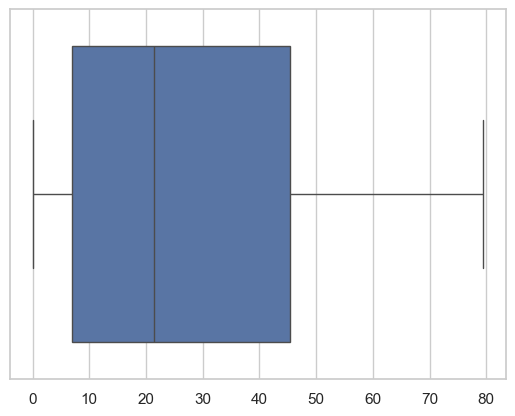

In [16]:
idea_potential_scores = np.array(list(idea_potential_score.values()))
print(f"Mean: {idea_potential_scores.mean():.2f}")
print(f"Std: {idea_potential_scores.std():.2f}")
print(f"Min: {idea_potential_scores.min():.2f}")
print(f"Max: {idea_potential_scores.max():.2f}")
print(f"Median: {np.median(idea_potential_scores):.2f}")
print(f"25%: {np.quantile(idea_potential_scores, 0.25):.2f}")
print(f"75%: {np.quantile(idea_potential_scores, 0.75):.2f}")
print(f"90%: {np.quantile(idea_potential_scores, 0.90):.2f}")
sns.boxplot(x=idea_potential_scores)



In [17]:
sorted(idea_potential_score.items(), key=lambda x: x[1], reverse=True)[:10]


[('conscription0', 79.5),
 ('quality0', 70.0),
 ('defensive0', 64.5),
 ('administrative_ideas', 61.5),
 ('weapon_quality0', 61.25),
 ('standing_army0', 60.5),
 ('quantity0', 60.0),
 ('fire0', 52.25),
 ('shock0', 51.25),
 ('nationalism0', 51.0)]

In [18]:
idea_policies_potential_score = Counter()
for idea_name in ALL_IDEA_NAMES:
    available_policies = [policy for policy in POLICIES.values() if idea_name in policy.req[0] or idea_name in policy.req[1]]
    for policy in available_policies:
        idea_policies_potential_score[idea_name] += get_score(policy.effect, [COUNTRY_WEIGHTS, MILITARY_WEIGHTS])
    

Mean: 129.99
Std: 58.39
Min: 2.00
Max: 244.50
Median: 134.75
25%: 94.94
75%: 174.88
90%: 200.70


<Axes: >

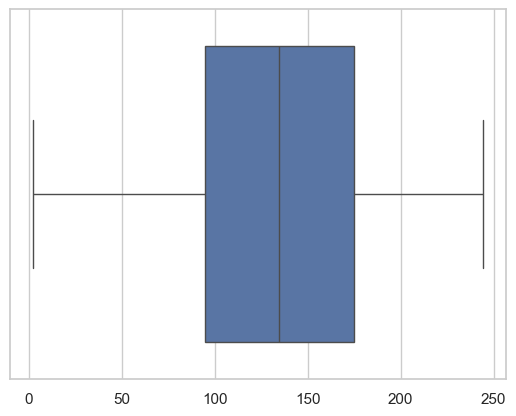

In [19]:
idea_policy_potential_scores = np.array(list(idea_policies_potential_score.values()))
print(f"Mean: {idea_policy_potential_scores.mean():.2f}")
print(f"Std: {idea_policy_potential_scores.std():.2f}")
print(f"Min: {idea_policy_potential_scores.min():.2f}")
print(f"Max: {idea_policy_potential_scores.max():.2f}")
print(f"Median: {np.median(idea_policy_potential_scores):.2f}")
print(f"25%: {np.quantile(idea_policy_potential_scores, 0.25):.2f}")
print(f"75%: {np.quantile(idea_policy_potential_scores, 0.75):.2f}")
print(f"90%: {np.quantile(idea_policy_potential_scores, 0.90):.2f}")
sns.boxplot(x=idea_policy_potential_scores)

In [20]:
sorted(idea_policies_potential_score.items(), key=lambda x: x[1], reverse=True)[:10]

[('conscription0', 244.5),
 ('centralisation0', 211.5),
 ('decentralisation0', 211.5),
 ('tactical0', 203.5),
 ('militarism0', 201.0),
 ('standing_army0', 200.0),
 ('economic_ideas', 192.25),
 ('weapon_quality0', 188.0),
 ('assimilation0', 185.5),
 ('shock0', 183.25)]

Mean: 156.27
Std: 74.95
Min: 2.00
Max: 324.00
Median: 152.57
25%: 112.94
75%: 213.75
90%: 247.05


<Axes: >

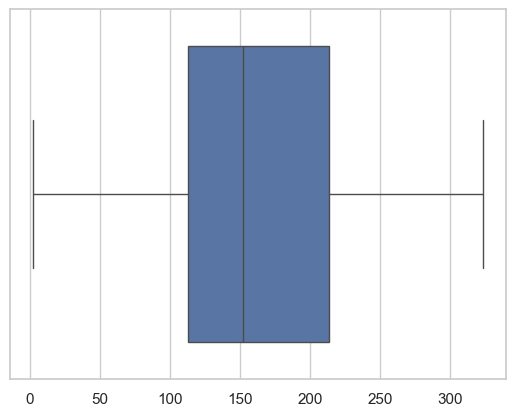

In [21]:
idea_combined_potential_score = {}
for idea_name in ALL_IDEA_NAMES:
   idea_combined_potential_score[idea_name] = idea_potential_score[idea_name] + idea_policies_potential_score[idea_name]
   
idea_combined_potential_scores = np.array(list(idea_combined_potential_score.values()))
print(f"Mean: {idea_combined_potential_scores.mean():.2f}")
print(f"Std: {idea_combined_potential_scores.std():.2f}")
print(f"Min: {idea_combined_potential_scores.min():.2f}")
print(f"Max: {idea_combined_potential_scores.max():.2f}")
print(f"Median: {np.median(idea_combined_potential_scores):.2f}")
print(f"25%: {np.quantile(idea_combined_potential_scores, 0.25):.2f}")
print(f"75%: {np.quantile(idea_combined_potential_scores, 0.75):.2f}")
print(f"90%: {np.quantile(idea_combined_potential_scores, 0.90):.2f}")
sns.boxplot(x=idea_combined_potential_scores)

In [22]:
sorted(idea_combined_potential_score.items(), key=lambda x: x[1], reverse=True)[:10]

[('conscription0', 324.0),
 ('standing_army0', 260.5),
 ('decentralisation0', 249.9),
 ('weapon_quality0', 249.25),
 ('quality0', 247.5),
 ('militarism0', 246.0),
 ('defensive0', 238.5),
 ('centralisation0', 235.25),
 ('shock0', 234.5),
 ('tactical0', 227.25)]

In [23]:
POTENTIAL_FILTERING = 25   
potential_threshold = np.quantile(
    idea_combined_potential_scores, POTENTIAL_FILTERING / 100)
ADM_IDEA_SCOPE = [
    idea_name for idea_name in ADM_IDEA_SCOPE if idea_combined_potential_score[idea_name] >= potential_threshold]
DIP_IDEA_SCOPE = [
    idea_name for idea_name in DIP_IDEA_SCOPE if idea_combined_potential_score[idea_name] >= potential_threshold]
MIL_IDEA_SCOPE = [
    idea_name for idea_name in MIL_IDEA_SCOPE if idea_combined_potential_score[idea_name] >= potential_threshold]
ideas_to_be_filtered_out = [ 
    idea_name for idea_name in ALL_IDEA_NAMES if idea_combined_potential_score[idea_name] < potential_threshold]
print(f'Ideas to be filtered out: {ideas_to_be_filtered_out}')

Ideas to be filtered out: ['expansion_ideas', 'state_administration0', 'catholic0', 'exploration_ideas', 'maritime_ideas', 'colonial_empire0', 'fleet_base0', 'galley0', 'heavy_ship0', 'light_ship0', 'mercenary0']


## Support

In [24]:
class Build():
    POLICY_TYPE_INDEX = {'ADM': 0, 'DIP': 1, 'MIL': 2}
    def __init__(self,
            idea_set: set[str] = None,
            idea_counts: [int, int, int] = None,
            cum_idea_score: float = 0,
            ideas_effect: Counter = None,
            policy_set: set[str] = None,
            max_policies: tuple[int, int, int] = None,
            war_policies: tuple[list[tuple[float, str]], list[tuple[float, str]], list[tuple[float, str]]] = None,
            dev_policies: tuple[list[tuple[float, str]], list[tuple[float, str]], list[tuple[float, str]]] = None,
            adm_tech_policies: tuple[list[tuple[float, str]], list[tuple[float, str]], list[tuple[float, str]]] = None,
            dip_tech_policies: tuple[list[tuple[float, str]], list[tuple[float, str]], list[tuple[float, str]]] = None,
            mil_tech_policies: tuple[list[tuple[float, str]], list[tuple[float, str]], list[tuple[float, str]]] = None,
            idea_policies: tuple[list[tuple[float, str]], list[tuple[float, str]], list[tuple[float, str]]] = None,
            total_score: float = 0,
        ):
        self.idea_set = idea_set if idea_set is not None else set()
        self.idea_counts = idea_counts if idea_counts is not None else (0, 0, 0)
        self.cum_idea_score = cum_idea_score if cum_idea_score is not None else 0
        self.ideas_effect = ideas_effect if ideas_effect is not None else Counter()
        self.policy_set = policy_set if policy_set is not None else set()
        self.max_policies = max_policies if max_policies is not None else (4, 4, 4)
        self.war_policies = war_policies if war_policies is not None else ([], [], [])
        self.dev_policies = dev_policies if dev_policies is not None else ([], [], [])
        self.adm_tech_policies = adm_tech_policies if adm_tech_policies is not None else ([], [], [])
        self.dip_tech_policies = dip_tech_policies if dip_tech_policies is not None else ([], [], [])
        self.mil_tech_policies = mil_tech_policies if mil_tech_policies is not None else ([], [], [])
        self.idea_policies = idea_policies if idea_policies is not None else ([], [], [])
        self.total_score = total_score if total_score is not None else 0

    def __repr__(self):
        return f"Build( {self.total_score:.2f} - ideas: {self.idea_set}"
    
    def print(self):
        print(f"Build( {self.total_score:.2f} - ideas: {self.idea_set}")
        print(f"    - Idea counts: {self.idea_counts}")
        print(f"    - Idea score: {self.cum_idea_score:.2f}")
        print(f"    - Idea effect: {self.ideas_effect}")
        print(f"    - Policies: {self.policy_set}")
        print(f"    - Max policies: {self.max_policies}")
        print(f"    - War policies: {self.war_policies}")
        print(f"    - Dev policies: {self.dev_policies}")
        print(f"    - Adm tech policies: {self.adm_tech_policies}")
        print(f"    - Dip tech policies: {self.dip_tech_policies}")
        print(f"    - Mil tech policies: {self.mil_tech_policies}")
        print(f"    - Idea policies: {self.idea_policies}")
        print(f"    - Total score: {self.total_score:.2f}")



In [25]:
def get_total_effect(build: Build):
    total_effect = Counter()
    total_effect.update(build.ideas_effect)
    
    adm_max_policies = build.max_policies[0] + build.ideas_effect['possible_policy'] + build.ideas_effect['possible_adm_policy']
    dip_max_policies = build.max_policies[1] + build.ideas_effect['possible_policy'] + build.ideas_effect['possible_dip_policy']
    mil_max_policies = build.max_policies[2] + build.ideas_effect['possible_policy'] + build.ideas_effect['possible_mil_policy']
    
    for policy in build.war_policies[0][:adm_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.war_policies[1][:dip_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.war_policies[2][:mil_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    
    for policy in build.dev_policies[0][:adm_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.dev_policies[1][:dip_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.dev_policies[2][:mil_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    
    for policy in build.adm_tech_policies[0][:adm_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.adm_tech_policies[1][:dip_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.adm_tech_policies[2][:mil_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
        
    for policy in build.dip_tech_policies[0][:adm_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.dip_tech_policies[1][:dip_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.dip_tech_policies[2][:mil_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
        
    for policy in build.mil_tech_policies[0][:adm_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.mil_tech_policies[1][:dip_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.mil_tech_policies[2][:mil_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
        
    for policy in build.idea_policies[0][:adm_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.idea_policies[1][:dip_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    for policy in build.idea_policies[2][:mil_max_policies]:
        total_effect.update(POLICIES[policy[1]].effect)
    
    return total_effect

In [26]:
EXPLORED_BUILDS = set()

def expanded_build(build: Build, idea_name: str,) -> Build:
    idea = IDEAS[idea_name]
    
    # Update Idea counts
    
    idea_counts = (
        build.idea_counts[0] + (idea_name in ADM_IDEA_SCOPE),
        build.idea_counts[1] + (idea_name in DIP_IDEA_SCOPE),
        build.idea_counts[2] + (idea_name in MIL_IDEA_SCOPE),
    )
        
    # Expand build with new idea
    
    idea_set = build.idea_set.copy()
    idea_set.add(idea_name)
    
    cum_idea_score = build.cum_idea_score + IDEA_SCORE[idea_name]
    
    ideas_effect = build.ideas_effect.copy()
    ideas_effect.update(idea.effect)
    
    # Check for new available policies and place them in order of importance
    
    policy_set = build.policy_set.copy()
    war_policies = copy.deepcopy(build.war_policies)
    dev_policies = copy.deepcopy(build.dev_policies)
    adm_tech_policies = copy.deepcopy(build.adm_tech_policies)
    dip_tech_policies = copy.deepcopy(build.dip_tech_policies)
    mil_tech_policies = copy.deepcopy(build.mil_tech_policies)
    idea_policies = copy.deepcopy(build.idea_policies)
    
    for build_idea in build.idea_set:
        policy_id = tuple(sorted([build_idea, idea_name]))
        if (policy := POLICY_LIB.get(policy_id)) and policy.name not in policy_set:
            policy_set.add(policy.name)  
            policy_war_score = POLICY_WAR_SCORE[policy.name]
            policy_dev_effect = get_development_effect(policy.effect)
            policy_adm_tech_effect = get_adm_tech_effect(policy.effect)
            policy_dip_tech_effect = get_dip_tech_effect(policy.effect)
            policy_mil_tech_effect = get_mil_tech_effect(policy.effect)
            policy_idea_effect = get_idea_effect(policy.effect)
            if policy_index := Build.POLICY_TYPE_INDEX.get(policy.type):
                if policy_war_score > 0:
                    bisect.insort(war_policies[policy_index], (policy_war_score, policy.name), key = lambda x: -1 * x[0])
                if policy_dev_effect > 0:
                    bisect.insort(dev_policies[policy_index], (policy_dev_effect, policy.name), key = lambda x: -1 * x[0])
                if policy_adm_tech_effect > 0:
                    bisect.insort(adm_tech_policies[policy_index], (policy_adm_tech_effect, policy.name), key = lambda x: -1 * x[0])
                if policy_dip_tech_effect > 0:
                    bisect.insort(dip_tech_policies[policy_index], (policy_dip_tech_effect, policy.name), key = lambda x: -1 * x[0])
                if policy_mil_tech_effect > 0:
                    bisect.insort(mil_tech_policies[policy_index], (policy_mil_tech_effect, policy.name), key = lambda x: -1 * x[0])
                if policy_idea_effect > 0:
                    bisect.insort(idea_policies[policy_index], (policy_idea_effect, policy.name), key = lambda x: -1 * x[0])                
                    
    # Create policy micro management effects
    
    adm_max_policies = build.max_policies[0] + ideas_effect['possible_policy'] + ideas_effect['possible_adm_policy']
    dip_max_policies = build.max_policies[1] + ideas_effect['possible_policy'] + ideas_effect['possible_dip_policy']
    mil_max_policies = build.max_policies[2] + ideas_effect['possible_policy'] + ideas_effect['possible_mil_policy']
    
    total_dev_effect = sum([policy[0] for policy in dev_policies[0][:adm_max_policies]]) + \
                                sum([policy[0] for policy in dev_policies[1][:dip_max_policies]]) + \
                                sum([policy[0] for policy in dev_policies[2][:mil_max_policies]])
    total_adm_tech_effect = sum([policy[0] for policy in adm_tech_policies[0][:adm_max_policies]]) + \
                                sum([policy[0] for policy in adm_tech_policies[1][:dip_max_policies]]) + \
                                sum([policy[0] for policy in adm_tech_policies[2][:mil_max_policies]])
    total_dip_tech_effect = sum([policy[0] for policy in dip_tech_policies[0][:adm_max_policies]]) + \
                                sum([policy[0] for policy in dip_tech_policies[1][:dip_max_policies]]) + \
                                sum([policy[0] for policy in dip_tech_policies[2][:mil_max_policies]])
    total_ida_effect = sum([policy[0] for policy in idea_policies[0][:adm_max_policies]]) + \
                                sum([policy[0] for policy in idea_policies[1][:dip_max_policies]]) + \
                                sum([policy[0] for policy in idea_policies[2][:mil_max_policies]])
                                
    micro_policy_effect = Counter()
    micro_policy_effect['development_cost'] = total_dev_effect
    micro_policy_effect['adm_tech_cost_modifier'] = total_adm_tech_effect
    micro_policy_effect['dip_tech_cost_modifier'] = total_dip_tech_effect
    micro_policy_effect['mil_tech_cost_modifier'] = total_dip_tech_effect
    micro_policy_effect['idea_cost'] = total_ida_effect
    
    # Create policy war effects
    
    war_policy_effect = Counter()
    for policy in war_policies[0][:adm_max_policies]:
        war_policy_effect.update(POLICIES[policy[1]].effect)
    for policy in war_policies[1][:dip_max_policies]:
        war_policy_effect.update(POLICIES[policy[1]].effect)
    for policy in war_policies[2][:mil_max_policies]:
        war_policy_effect.update(POLICIES[policy[1]].effect)
        
    # Calculate total score
    
    total_score = cum_idea_score + get_score(micro_policy_effect, [COUNTRY_WEIGHTS]) + get_score(war_policy_effect, [MILITARY_WEIGHTS])
    
    return Build(
        idea_set = idea_set,
        idea_counts = idea_counts,
        cum_idea_score = cum_idea_score,
        ideas_effect = ideas_effect,
        policy_set = policy_set,
        max_policies = build.max_policies,
        war_policies = war_policies,
        dev_policies = dev_policies,
        adm_tech_policies = adm_tech_policies,
        dip_tech_policies = dip_tech_policies,
        mil_tech_policies = mil_tech_policies,
        idea_policies = idea_policies,
        total_score = total_score,
    )

In [27]:
build = Build()
expanded_build_1 = expanded_build(build, 'strongman0')
expanded_build_2 = expanded_build(expanded_build_1, 'weapon_quality0')
expanded_build_3 = expanded_build(expanded_build_2, 'imperialism0')
expanded_build_4 = expanded_build(expanded_build_3, 'quality0')
expanded_build_5 = expanded_build(expanded_build_4, 'economic_ideas')
expanded_build_6 = expanded_build(expanded_build_5, 'society0')

In [28]:
expanded_build_6.print()

Build( 315.50 - ideas: {'imperialism0', 'society0', 'quality0', 'strongman0', 'weapon_quality0', 'economic_ideas'}
    - Idea counts: (2, 2, 2)
    - Idea score: 218.00
    - Idea effect: Counter({'max_absolutism': 10, 'global_unrest': 3, 'merchants': 1, 'army_tradition': 1, 'interest': 1, 'advisor_pool': 1, 'navy_tradition': 0.5, 'naval_attrition': 0.33, 'global_tax_modifier': 0.30000000000000004, 'production_efficiency': 0.275, 'siege_ability': 0.25, 'manpower_recovery_speed': 0.25, 'global_manpower_modifier': 0.2, 'infantry_power': 0.2, 'cavalry_power': 0.2, 'artillery_power': 0.2, 'development_cost': 0.2, 'inflation_action_cost': 0.2, 'global_trade_goods_size_modifier': 0.175, 'land_maintenance_modifier': 0.15000000000000002, 'naval_forcelimit_modifier': 0.15, 'improve_relation_modifier': 0.15, 'discipline': 0.125, 'defensiveness': 0.1, 'naval_morale': 0.1, 'inflation_reduction': 0.1, 'build_cost': 0.1, 'build_time': 0.1, 'global_institution_spread': 0.1, 'advisor_cost': 0.1, 'glob

In [29]:
get_total_effect(expanded_build_6)

Counter({'max_absolutism': 10,
         'global_unrest': 3,
         'merchants': 1,
         'army_tradition': 1,
         'interest': 1,
         'advisor_pool': 1,
         'navy_tradition': 0.5,
         'artillery_power': 0.4,
         'naval_attrition': 0.33,
         'global_tax_modifier': 0.30000000000000004,
         'infantry_power': 0.30000000000000004,
         'cavalry_power': 0.30000000000000004,
         'production_efficiency': 0.275,
         'siege_ability': 0.25,
         'manpower_recovery_speed': 0.25,
         'land_morale': 0.25,
         'global_manpower_modifier': 0.2,
         'development_cost': 0.2,
         'inflation_action_cost': 0.2,
         'global_trade_goods_size_modifier': 0.175,
         'discipline': 0.175,
         'land_maintenance_modifier': 0.15000000000000002,
         'naval_forcelimit_modifier': 0.15,
         'improve_relation_modifier': 0.15,
         'defensiveness': 0.1,
         'naval_morale': 0.1,
         'inflation_reduction': 0.1,

## Find the best build

In [30]:
IDEA_COUNT_THRESHOLD = 0.39

def iter_expanding_ideas(build: Build) -> str:
    adm_idea_count, dip_idea_count, mil_idea_count = build.idea_counts
    idea_count = adm_idea_count + dip_idea_count + mil_idea_count
    if adm_idea_count / idea_count < IDEA_COUNT_THRESHOLD:
        for idea_name in ADM_IDEA_SCOPE:
            if idea_name not in build.idea_set:
                for idea_conflict in IDEA_NOT_COMPATIBLE[idea_name]:
                    if idea_conflict in build.idea_set:
                        break
                else:
                    yield idea_name
    if dip_idea_count / idea_count < IDEA_COUNT_THRESHOLD:
        for idea_name in DIP_IDEA_SCOPE:
            if idea_name not in build.idea_set:
                for idea_conflict in IDEA_NOT_COMPATIBLE[idea_name]:
                    if idea_conflict in build.idea_set:
                        break
                else:
                    yield idea_name
    if mil_idea_count / idea_count < IDEA_COUNT_THRESHOLD:
        for idea_name in MIL_IDEA_SCOPE:
            if idea_name not in build.idea_set:
                for idea_conflict in IDEA_NOT_COMPATIBLE[idea_name]:
                    if idea_conflict in build.idea_set:
                        break
                else:
                    yield idea_name
                    
EXPAND_BEST_N = 1000
EXPAND_RANDOM_N = 3000

def get_ideas_to_expand(build_list: list[Build], best_n=EXPAND_BEST_N, random_n=EXPAND_RANDOM_N):
    build_list.sort(key=lambda x: x.total_score, reverse=True)
    best_builds = build_list[:best_n]
    random_builds = random.sample(build_list[best_n:], min(random_n, len(build_list[best_n:])))
    return best_builds + random_builds

In [31]:
OUTPUT_PATH = '../output/_dev/build_search/'

def dump_builds(builds: list[Build], output_path: str, count: int = 100, highlights: list[str] = HIGHLIGHTS):
    with open(output_path, 'w') as f:
        for build in builds[:count]:
            build_total_effect = get_total_effect(build)
            f.write('---------------------------------------------------\n')
            f.write(f'Score: {build.total_score}\n')
            f.write(f'Ideas: {build.idea_set}\n')
            f.write('     Main effects:\n')
            for highlight in highlights:
                f.write(
                    f'          {highlight}: {build_total_effect.get(highlight, 0)}\n')
            f.write('     Other effects:\n')
            for effect, value in build_total_effect.items():
                if not effect in highlights:
                    f.write(f'          {effect}: {value}\n')

## 3-policy builds

In [32]:
total_options = len(ADM_IDEA_SCOPE) *  len(DIP_IDEA_SCOPE) * len(MIL_IDEA_SCOPE)
init_builds = []
with tqdm(total=total_options) as pbar:
    for adm_idea in ADM_IDEA_SCOPE:
        init_build_adm = expanded_build(Build(), adm_idea)
        for dip_idea in DIP_IDEA_SCOPE:
            init_build_dip = expanded_build(init_build_adm, dip_idea)
            for mil_idea in MIL_IDEA_SCOPE:
                init_build_mil = expanded_build(init_build_dip, mil_idea)
                init_builds.append(init_build_mil)
                pbar.update(1)

  0%|          | 0/1260 [00:00<?, ?it/s]

In [33]:
dump_builds(init_builds, OUTPUT_PATH + 'init_builds.txt', count=100)

## Expanding init builds

In [34]:
CUTTING_FROM = 5
CUTTING_TOP = 1000
CUTTING_RANDOM = 3000

expanded_builds = init_builds

for i in range(4, 13):
    builds_to_expand = list(expanded_builds)
    expanded_builds = []
    for build in tqdm(builds_to_expand, desc=f'Searching for {i} ideas'):
        for idea_name in iter_expanding_ideas(build):
            build_idea_set = set(build.idea_set)
            build_idea_set.add(idea_name)
            build_id = '-'.join(sorted(list(build_idea_set)))
            if build_id not in EXPLORED_BUILDS:
                expanded_builds.append(expanded_build(build, idea_name))
    
    expanded_builds.sort(key=lambda x: x.total_score, reverse=True)
    if i >= CUTTING_FROM:
        expanded_builds = get_ideas_to_expand(expanded_builds, best_n=CUTTING_TOP, random_n=CUTTING_RANDOM)
    dump_builds(expanded_builds, OUTPUT_PATH + f'builds_{i}.txt', count=100)

Expanding 3 idea sets:   0%|          | 0/1260 [00:00<?, ?it/s]

Expanding 4 idea sets:   0%|          | 0/36828 [00:00<?, ?it/s]

Expanding 5 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

Expanding 6 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

Expanding 7 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

Expanding 8 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

Expanding 9 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

Expanding 10 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

Expanding 11 idea sets:   0%|          | 0/4000 [00:00<?, ?it/s]

In [35]:
expanded_builds[0].dev_policies

([],
 [(0.1, 'idea_variation_act_514'), (0.1, 'idea_variation_act_153')],
 [(0.1, 'idea_variation_act_566')])

In [36]:
build = Build()
for idea_name in ['imperialism0', 'administrative_ideas', 'quality0', 'conscription0']:
    build = expanded_build(build, idea_name)
build.print()

Build( 277.75 - ideas: {'imperialism0', 'conscription0', 'quality0', 'administrative_ideas'}
    - Idea counts: (1, 1, 2)
    - Idea score: 236.50
    - Idea effect: Counter({'max_absolutism': 10, 'global_manpower': 5.0, 'army_tradition': 2, 'country_admin_power': 1, 'country_diplomatic_power': 1, 'interest': 1, 'navy_tradition': 0.5, 'manpower_recovery_speed': 0.5, 'drill_gain_modifier': 0.5, 'monarch_lifespan': 0.33, 'naval_attrition': 0.33, 'global_regiment_recruit_speed': 0.33, 'land_morale': 0.3, 'embracement_cost': 0.25, 'governing_capacity_modifier': 0.25, 'reinforce_speed': 0.25, 'global_manpower_modifier': 0.25, 'core_creation': 0.2, 'advisor_cost': 0.2, 'naval_forcelimit_modifier': 0.15, 'development_cost': 0.1, 'global_tax_modifier': 0.1, 'adm_tech_cost_modifier': 0.1, 'cavalry_power': 0.1, 'artillery_power': 0.1, 'naval_morale': 0.1, 'infantry_power': 0.1, 'mil_tech_cost_modifier': 0.1, 'discipline': 0.07500000000000001, 'imperial_authority_value': 0.05, 'imperial_mandate':

In [37]:
get_total_effect(build)

Counter({'max_absolutism': 10,
         'global_manpower': 5.0,
         'army_tradition': 2,
         'country_admin_power': 1,
         'country_diplomatic_power': 1,
         'interest': 1,
         'navy_tradition': 0.5,
         'manpower_recovery_speed': 0.5,
         'drill_gain_modifier': 0.5,
         'land_morale': 0.4,
         'monarch_lifespan': 0.33,
         'naval_attrition': 0.33,
         'global_regiment_recruit_speed': 0.33,
         'embracement_cost': 0.25,
         'governing_capacity_modifier': 0.25,
         'reinforce_speed': 0.25,
         'global_manpower_modifier': 0.25,
         'core_creation': 0.2,
         'advisor_cost': 0.2,
         'infantry_power': 0.2,
         'naval_forcelimit_modifier': 0.15,
         'development_cost': 0.1,
         'global_tax_modifier': 0.1,
         'adm_tech_cost_modifier': 0.1,
         'cavalry_power': 0.1,
         'artillery_power': 0.1,
         'naval_morale': 0.1,
         'mil_tech_cost_modifier': 0.1,
         'd

: 